In [98]:
import pandas as pd
from scipy import stats
import numpy as np
from scipy.stats import wilcoxon
import seaborn as sns
import matplotlib.pyplot as plt

In [100]:
file_path = '/Users/harriethe/Downloads/Questioneer.xlsx'
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip()

In [102]:
df_new = pd.read_csv('/Users/harriethe/Downloads/Question_new.csv')

In [104]:
# 1. Remove rows where Timepoint is '0'
df_cleaned = df_new[df_new['Timepoint relative to drug administration (in minutes)'] != '0']

# 2. Replace 'baseline' with 0 in the Timepoint column
df_cleaned['Timepoint relative to drug administration (in minutes)'] = df_cleaned['Timepoint relative to drug administration (in minutes)'].replace('baseline', 0)

df_cleaned = df_cleaned[df_cleaned['Timepoint relative to drug administration (in minutes)'] != 'Avg from capsule to 360']
# 3. Replace 'ms' (missing) values with NaN throughout the entire DataFrame
df_cleaned = df_cleaned.replace('ms', np.nan)

df_cleaned['Timepoint relative to drug administration (in minutes)'] = pd.to_numeric(df_cleaned['Timepoint relative to drug administration (in minutes)'], errors='coerce')

timepoints = df_cleaned['Timepoint relative to drug administration (in minutes)'].unique()
print(timepoints)

[  0  30  60 120 180 240 300 360]


/var/folders/fh/_crmyvv94rjbbn8m0gv12w2r0000gn/T/ipykernel_15578/2506174059.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Timepoint relative to drug administration (in minutes)'] = df_cleaned['Timepoint relative to drug administration (in minutes)'].replace('baseline', 0)


In [106]:
rating_columns = [
    '1. Overall Psilocybin Effect (0 = none to\n10 = strongest imaginable)',
    '2. Now-ness (0 = none to\n10 = strongest imaginable)',
    '3. Letting Go (0 = none to\n10 = strongest imaginable)',
    '4. Equanimity (0 = none to\n10 = strongest imaginable)',
    '5. Pure being and pure awareness (0 = none to\n10 = strongest imaginable)',
    '6. Fusion of your personal self into a larger whole (0 = none to\n10 = strongest imaginable)',
    '7. Sense of reverence or sacredness (0 = none to\n10 = strongest imaginable)',
    '8. Timelessness (0 = none to\n10 = strongest imaginable)',
    '9. Ineffability (0 = none to\n10 = strongest imaginable)',
    '10. Feelings of joy (0 = none to\n10 = strongest imaginable)',
    '11. Feelings of peace and tranquility (0 = none to\n10 = strongest imaginable)',
    '12. Positive Emotional Valence (0 = none to\n10 = strongest imaginable)',
    '13. Negative emotional valence  (0 = none to\n10 = strongest imaginable)'
]

m = len(rating_columns)

In [108]:
df_cleaned.columns = df_cleaned.columns.str.strip()
#print(df_filtered.columns)

df_cleaned[rating_columns] = df_cleaned[rating_columns].apply(pd.to_numeric, errors='coerce')

# Check if the conversion worked by printing the dtypes
#print(df_filtered[rating_columns].dtypes)

## Checking NA in df_cleaned

Q4 has 10 missing but it wasn't a reason why

In [110]:
for timepoint in timepoints:
    df_timepoint = df_cleaned[df_cleaned['Timepoint relative to drug administration (in minutes)'] == timepoint]
    print(f"Missing values for Timepoint {timepoint} (minutes):")
    print(df_timepoint[rating_columns].isna().sum()) 
total_missing_values = df_cleaned[rating_columns].isna().sum()
print("Total missing values across all time points for each question:")
print(total_missing_values)

Missing values for Timepoint 0 (minutes):
1. Overall Psilocybin Effect (0 = none to\n10 = strongest imaginable)                           0
2. Now-ness (0 = none to\n10 = strongest imaginable)                                            0
3. Letting Go (0 = none to\n10 = strongest imaginable)                                          0
4. Equanimity (0 = none to\n10 = strongest imaginable)                                          0
5. Pure being and pure awareness (0 = none to\n10 = strongest imaginable)                       0
6. Fusion of your personal self into a larger whole (0 = none to\n10 = strongest imaginable)    0
7. Sense of reverence or sacredness (0 = none to\n10 = strongest imaginable)                    0
8. Timelessness (0 = none to\n10 = strongest imaginable)                                        0
9. Ineffability (0 = none to\n10 = strongest imaginable)                                        0
10. Feelings of joy (0 = none to\n10 = strongest imaginable)                

## Sections for Pair T Test

In [112]:
from scipy import stats
paired_results_by_time = {}

for timepoint in timepoints:
    df_timepoint = df_cleaned[df_cleaned['Timepoint relative to drug administration (in minutes)'] == timepoint]
    placebo_scores = df_timepoint[df_timepoint['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'PLA'][rating_columns]
    exp_scores = df_timepoint[df_timepoint['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'EXP'][rating_columns]
    paired_results_by_time[timepoint] = {}
    for col in rating_columns:
        if len(placebo_scores[col]) == len(exp_scores[col]) and len(placebo_scores[col]) > 0: 
            t_stat, p_value = stats.ttest_rel(placebo_scores[col], exp_scores[col], nan_policy='omit')
            log_p_value = -np.log10(p_value) if p_value > 0 else None
            paired_results_by_time[timepoint][col] = (t_stat, log_p_value) 
        else:
            paired_results_by_time[timepoint][col] = (None, None)  

    print(f"Results for Timepoint {timepoint} (minutes):")
    for col, (t_stat, log_p_value) in paired_results_by_time[timepoint].items():
        print(f"{col}: T-statistic = {t_stat}, -log10(P-value) = {log_p_value}")
    print("\n")

Results for Timepoint 0 (minutes):
1. Overall Psilocybin Effect (0 = none to
10 = strongest imaginable): T-statistic = nan, -log10(P-value) = None
2. Now-ness (0 = none to
10 = strongest imaginable): T-statistic = 0.18797789509922808, -log10(P-value) = 0.06915886514948631
3. Letting Go (0 = none to
10 = strongest imaginable): T-statistic = -0.7056967961720457, -log10(P-value) = 0.31112136557311854
4. Equanimity (0 = none to
10 = strongest imaginable): T-statistic = -0.9687189593929654, -log10(P-value) = 0.46311943112020176
5. Pure being and pure awareness (0 = none to
10 = strongest imaginable): T-statistic = 0.6913837373523726, -log10(P-value) = 0.3034058432732242
6. Fusion of your personal self into a larger whole (0 = none to
10 = strongest imaginable): T-statistic = 0.657595949221429, -log10(P-value) = 0.2854227198691093
7. Sense of reverence or sacredness (0 = none to
10 = strongest imaginable): T-statistic = 0.10347288589592778, -log10(P-value) = 0.0368649478147384
8. Timelessnes

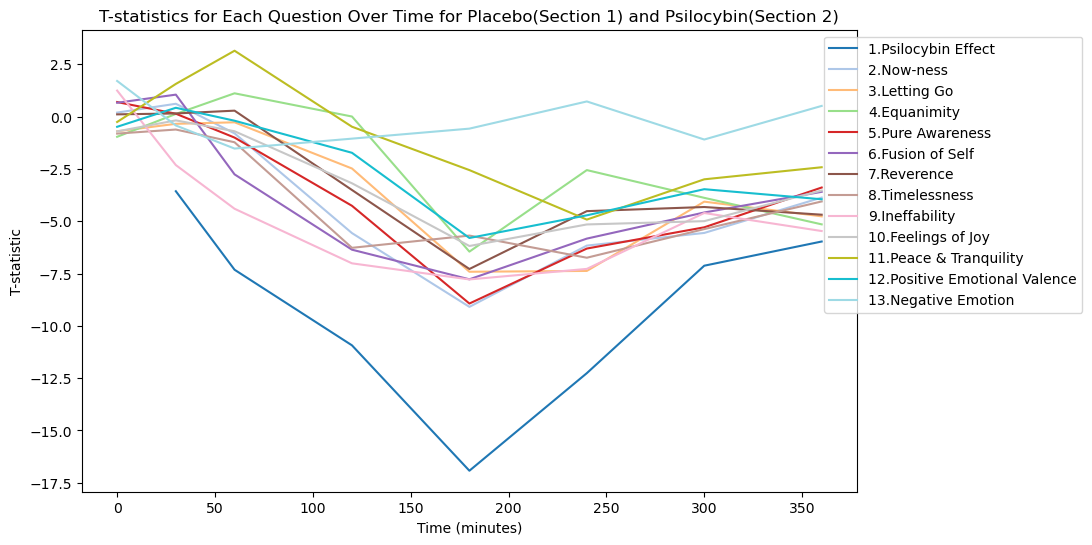

In [114]:
import matplotlib.pyplot as plt

shortened_rating_columns = [
    '1.Psilocybin Effect', '2.Now-ness', '3.Letting Go', '4.Equanimity', '5.Pure Awareness', 
    '6.Fusion of Self', '7.Reverence', '8.Timelessness', '9.Ineffability', 
    '10.Feelings of Joy', '11.Peace & Tranquility', '12.Positive Emotional Valence', '13.Negative Emotion'
]

timepoints = list(paired_results_by_time.keys())
t_stats_by_question = {col: [] for col in rating_columns}
for timepoint in timepoints:
    for col in rating_columns:
        t_stat, _ = paired_results_by_time[timepoint][col]
        t_stats_by_question[col].append(t_stat)
plt.figure(figsize=(10, 6))
#for col in rating_columns:
    #plt.plot(timepoints, t_stats_by_question[col], label=col)
cmap = plt.get_cmap('tab20', len(shortened_rating_columns))

for i,(col, short_col) in enumerate(zip(rating_columns, shortened_rating_columns)):
    plt.plot(timepoints, t_stats_by_question[col], label=short_col,color=cmap(i))
plt.xlabel('Time (minutes)')
plt.ylabel('T-statistic')
plt.title('T-statistics for Each Question Over Time for Placebo(Section 1) and Psilocybin(Section 2)')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

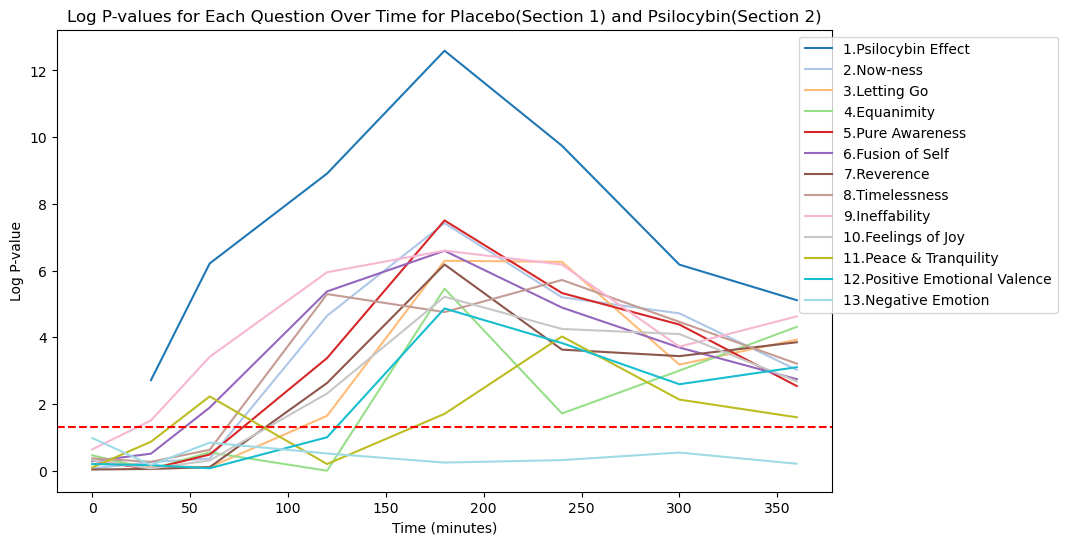

In [118]:
log_p_values_by_question = {col: [] for col in rating_columns}

for timepoint in timepoints:
    for col in rating_columns:
        _, log_p_value = paired_results_by_time[timepoint][col]
        log_p_values_by_question[col].append(log_p_value)

plt.figure(figsize=(10, 6))
#for col in rating_columns:
    #plt.plot(timepoints, p_values_by_question[col], label=col)
for i,(col, short_col) in enumerate(zip(rating_columns, shortened_rating_columns)):
    plt.plot(timepoints, log_p_values_by_question[col], label=short_col,color=cmap(i))
plt.xlabel('Time (minutes)')
plt.ylabel('Log P-value')
plt.title('Log P-values for Each Question Over Time for Placebo(Section 1) and Psilocybin(Section 2)')
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--')  
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

## This Section is for Wilcoxon ##

Wilcoxon is not good with NaN

In [120]:
df_cleaned_imputed = df_cleaned.copy()

imputation_summary = {col: {'count_before': 0, 'sum_before': 0, 'sum_after': 0, 'imputed_count': 0} for col in rating_columns}

if all(col in df_cleaned_imputed.columns for col in rating_columns):
    for col in rating_columns:
        missing_before = df_cleaned_imputed[col].isnull()
        imputation_summary[col]['count_before'] = missing_before.sum()
        imputation_summary[col]['sum_before'] = df_cleaned_imputed[col].sum(skipna=True)
    df_cleaned_imputed[rating_columns] = df_cleaned_imputed[rating_columns].interpolate(method='linear', limit_direction='both')
    for col in rating_columns:
        missing_after = df_cleaned_imputed[col].isnull()
        imputation_summary[col]['sum_after'] = df_cleaned_imputed[col].sum(skipna=True)
        imputation_summary[col]['imputed_count'] = imputation_summary[col]['count_before'] - missing_after.sum()

    print("Imputation Summary:")
    for question, stats in imputation_summary.items():
        count_diff = stats['imputed_count']
        sum_diff = stats['sum_after'] - stats['sum_before']
        print(f"{question}: Imputed Count = {count_diff}, Sum Before = {stats['sum_before']}, Sum After = {stats['sum_after']}, Increase in Sum = {sum_diff}")

else:
    print("Some columns in rating_columns are not found in the DataFrame.")

Imputation Summary:
1. Overall Psilocybin Effect (0 = none to
10 = strongest imaginable): Imputed Count = 6, Sum Before = 1748.0, Sum After = 1793.5, Increase in Sum = 45.5
2. Now-ness (0 = none to
10 = strongest imaginable): Imputed Count = 8, Sum Before = 3130.0, Sum After = 3196.5, Increase in Sum = 66.5
3. Letting Go (0 = none to
10 = strongest imaginable): Imputed Count = 9, Sum Before = 3209.0, Sum After = 3284.0, Increase in Sum = 75.0
4. Equanimity (0 = none to
10 = strongest imaginable): Imputed Count = 10, Sum Before = 3168.0, Sum After = 3228.0, Increase in Sum = 60.0
5. Pure being and pure awareness (0 = none to
10 = strongest imaginable): Imputed Count = 10, Sum Before = 2573.0, Sum After = 2645.0, Increase in Sum = 72.0
6. Fusion of your personal self into a larger whole (0 = none to
10 = strongest imaginable): Imputed Count = 11, Sum Before = 2352.0, Sum After = 2423.5, Increase in Sum = 71.5
7. Sense of reverence or sacredness (0 = none to
10 = strongest imaginable): Im

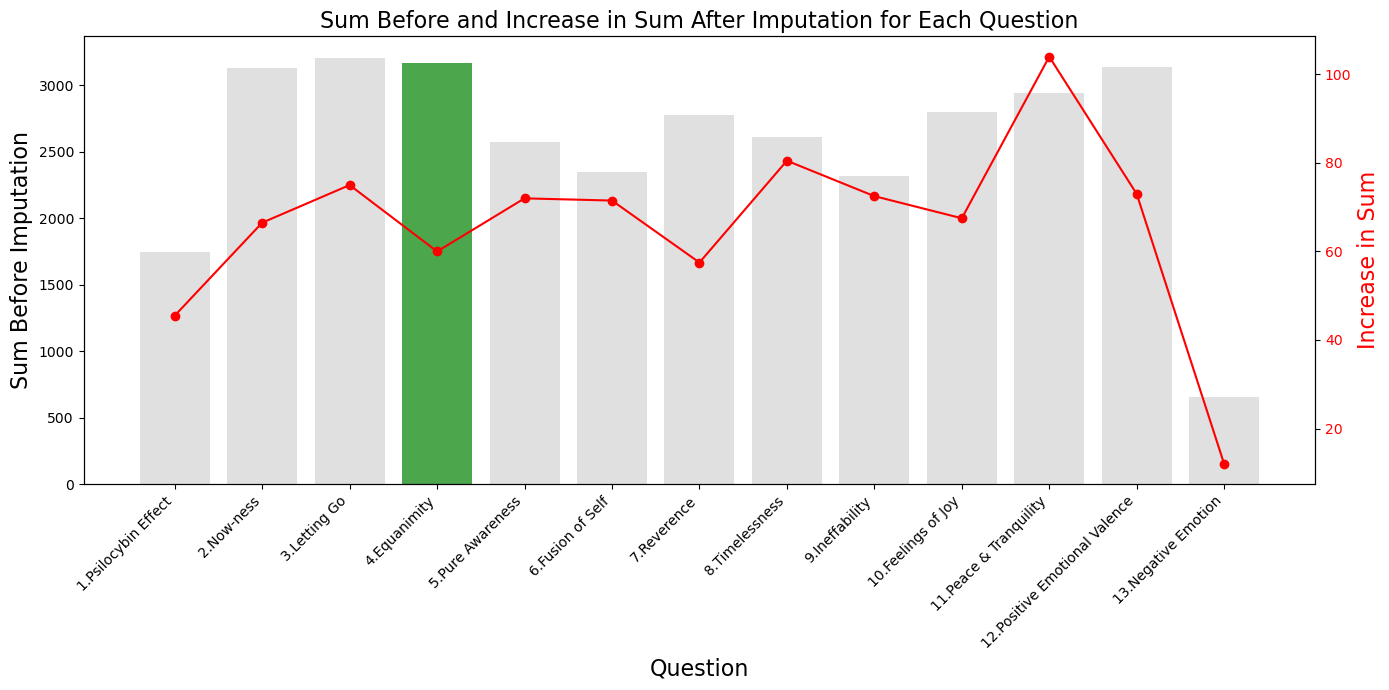

In [122]:
questions = shortened_rating_columns
sum_before = [imputation_summary[q]['sum_before'] for q in rating_columns]
increase_in_sums = [imputation_summary[q]['sum_after'] - imputation_summary[q]['sum_before'] for q in rating_columns]

# Highlight color for the specific question (Q4)
bar_colors = ['lightgray' if q != '4.Equanimity' else 'green' for q in questions]
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.bar(questions, sum_before, color=bar_colors, alpha=0.7)
ax1.set_xlabel('Question', fontsize=16)
ax1.set_ylabel('Sum Before Imputation', fontsize=16, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks(np.arange(len(questions)))
ax1.set_xticklabels(questions, rotation=45, ha='right', fontsize=10)
ax2 = ax1.twinx()
ax2.plot(questions, increase_in_sums, color='red', marker='o', label='Increase in Sum')
ax2.set_ylabel('Increase in Sum', fontsize=16, color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('Sum Before and Increase in Sum After Imputation for Each Question', fontsize=16)
fig.tight_layout()
plt.show()

In [124]:
from statsmodels.stats.multitest import multipletests
wilcoxon_results_by_time = {}
m = len(rating_columns)

for timepoint in timepoints:
    df_timepoint = df_cleaned_imputed[df_cleaned_imputed['Timepoint relative to drug administration (in minutes)'] == timepoint]
    placebo_scores = df_timepoint[df_timepoint['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'PLA'][rating_columns]
    exp_scores = df_timepoint[df_timepoint['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'EXP'][rating_columns]  # Make sure `exp_scores` is correctly defined here
    
    wilcoxon_results_by_time[timepoint] = {}
    wilcoxon_p_values = []
    wilcoxon_test_stats = []

    for col in rating_columns:
        try:
            wilcoxon_t_stat, wilcoxon_p_value = wilcoxon(placebo_scores[col], exp_scores[col], zero_method='wilcox', correction=False)
            wilcoxon_p_values.append(wilcoxon_p_value)
            wilcoxon_test_stats.append(wilcoxon_t_stat)
        except ValueError:
            wilcoxon_p_values.append(np.nan)  # Use NaN instead of 1
            wilcoxon_test_stats.append(None)
                    
    adjusted_p_values = multipletests(wilcoxon_p_values, alpha=0.05, method='holm')[1]

    for col, wilcoxon_t_stat, adj_p_value in zip(rating_columns, wilcoxon_test_stats, adjusted_p_values):
        wilcoxon_results_by_time[timepoint][col] = (wilcoxon_t_stat, adj_p_value)  # Store the adjusted p-value for each column


    print(f"Results for Timepoint {timepoint} (minutes):")
    for col, (wilcoxon_t_stat, adj_p_value) in wilcoxon_results_by_time[timepoint].items():
        print(f"{col}: Wilcoxon statistic = {wilcoxon_t_stat}, Bonferroni-Holm adjusted P-value = {adj_p_value}")
    print("\n")

/Users/harriethe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/harriethe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Results for Timepoint 0 (minutes):
1. Overall Psilocybin Effect (0 = none to
10 = strongest imaginable): Wilcoxon statistic = None, Bonferroni-Holm adjusted P-value = nan
2. Now-ness (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 37.5, Bonferroni-Holm adjusted P-value = 1.0
3. Letting Go (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 74.0, Bonferroni-Holm adjusted P-value = 1.0
4. Equanimity (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 59.5, Bonferroni-Holm adjusted P-value = 1.0
5. Pure being and pure awareness (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 43.5, Bonferroni-Holm adjusted P-value = 1.0
6. Fusion of your personal self into a larger whole (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 33.5, Bonferroni-Holm adjusted P-value = 1.0
7. Sense of reverence or sacredness (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 74.0, Bonferroni-Holm adjusted P-value = 1.0
8. Timelessness (0 = none 

/Users/harriethe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/harriethe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/harriethe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Results for Timepoint 120 (minutes):
1. Overall Psilocybin Effect (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 1.0, Bonferroni-Holm adjusted P-value = 2.47955322265625e-05
2. Now-ness (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 5.0, Bonferroni-Holm adjusted P-value = 0.0015854765941606243
3. Letting Go (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 34.0, Bonferroni-Holm adjusted P-value = 0.06787807954907459
4. Equanimity (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 110.0, Bonferroni-Holm adjusted P-value = 1.0
5. Pure being and pure awareness (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 23.5, Bonferroni-Holm adjusted P-value = 0.029994623306758113
6. Fusion of your personal self into a larger whole (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 1.0, Bonferroni-Holm adjusted P-value = 0.0010627879976395915
7. Sense of reverence or sacredness (0 = none to
10 = strongest imaginable): Wilcox

/Users/harriethe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/harriethe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Results for Timepoint 240 (minutes):
1. Overall Psilocybin Effect (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 0.0, Bonferroni-Holm adjusted P-value = 1.239776611328125e-05
2. Now-ness (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 2.5, Bonferroni-Holm adjusted P-value = 0.0012178612713498508
3. Letting Go (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 0.0, Bonferroni-Holm adjusted P-value = 0.0012178612713498508
4. Equanimity (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 24.5, Bonferroni-Holm adjusted P-value = 0.027056656979213917
5. Pure being and pure awareness (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 0.0, Bonferroni-Holm adjusted P-value = 0.001325228379390167
6. Fusion of your personal self into a larger whole (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 0.0, Bonferroni-Holm adjusted P-value = 0.0012178612713498508
7. Sense of reverence or sacredness (0 = none to
10 = strongest im

/Users/harriethe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


<function matplotlib.pyplot.show(close=None, block=None)>

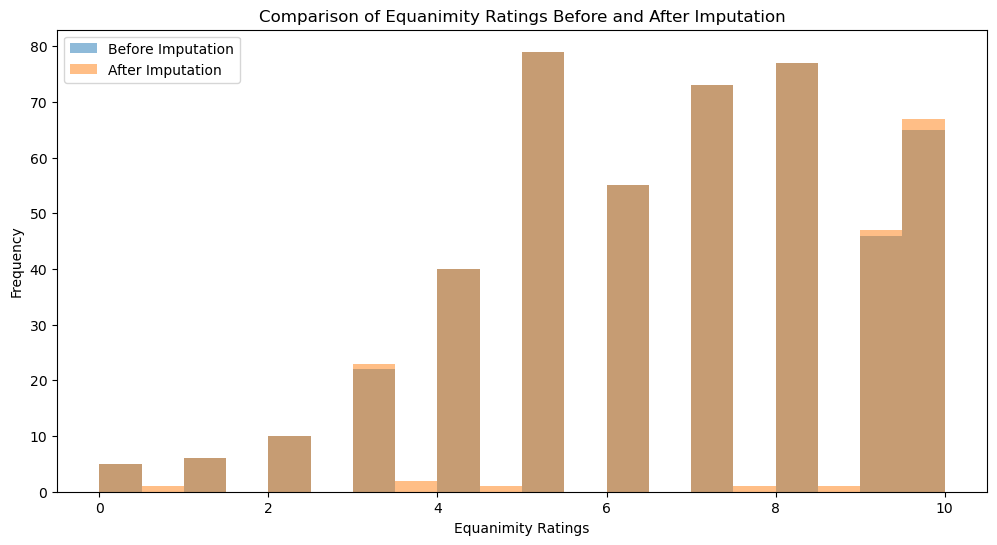

In [248]:
plt.figure(figsize=(12, 6))
plt.hist(df_cleaned['4. Equanimity (0 = none to\n10 = strongest imaginable)'], bins=20, alpha=0.5, label='Before Imputation')
plt.hist(df_cleaned_imputed['4. Equanimity (0 = none to\n10 = strongest imaginable)'], bins=20, alpha=0.5, label='After Imputation')
plt.xlabel('Equanimity Ratings')
plt.ylabel('Frequency')
plt.title('Comparison of Equanimity Ratings Before and After Imputation')
plt.legend()
plt.show

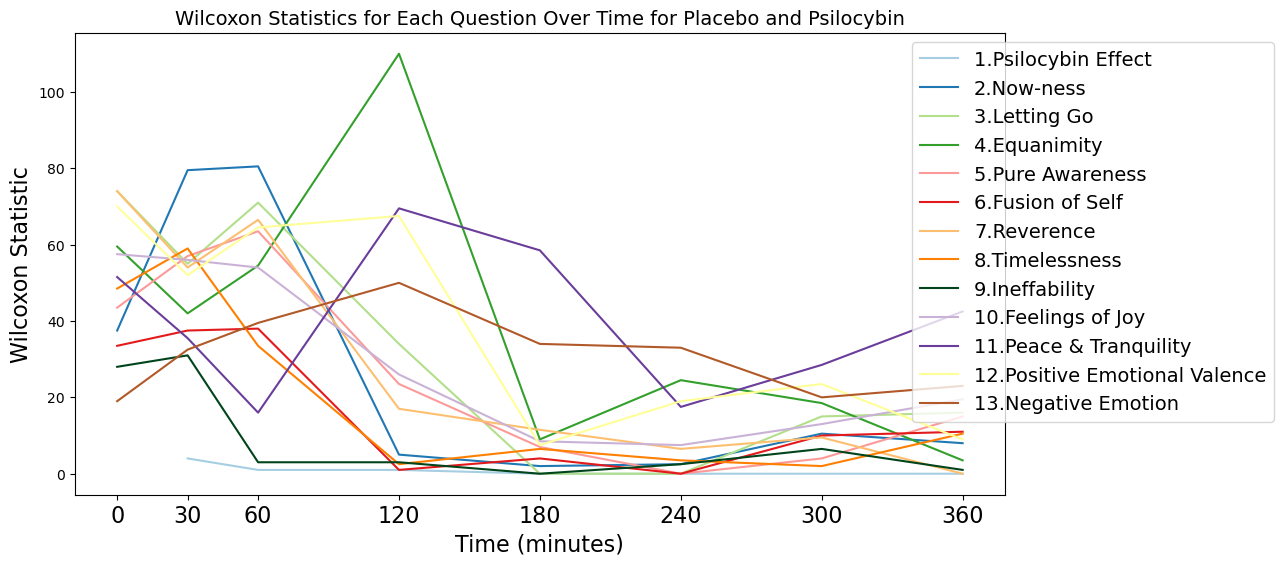

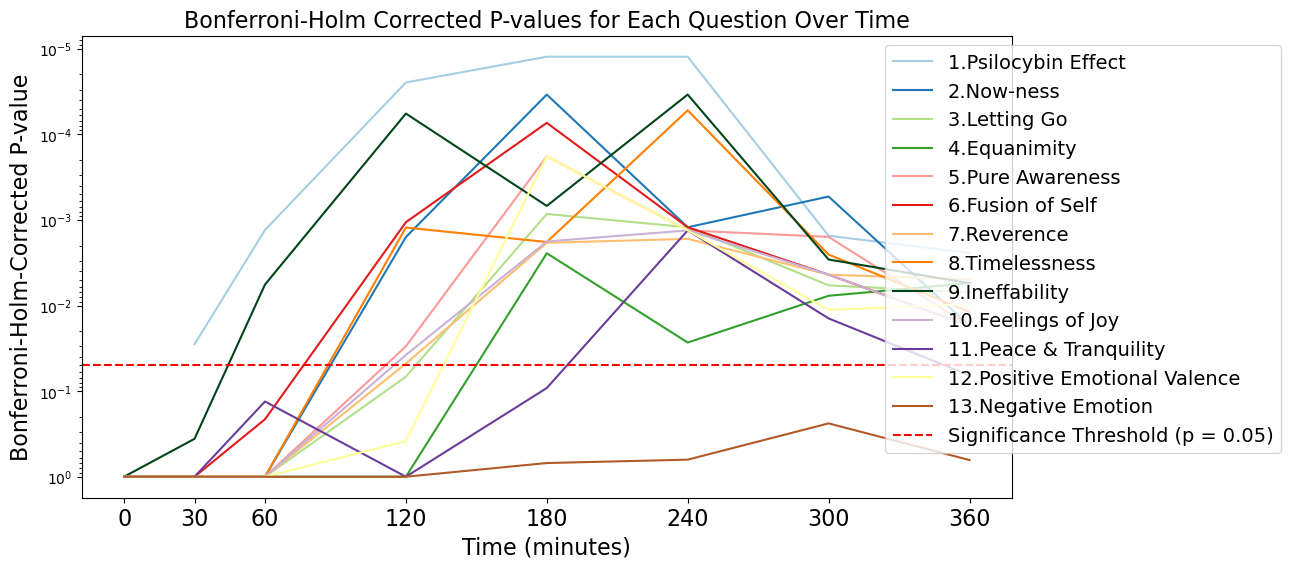

In [132]:
from statsmodels.stats.multitest import multipletests
import numpy as np
import matplotlib.pyplot as plt

# Assuming wilcoxon_results_by_time has been generated as in your provided code

specific_timepoints = [0, 30, 60, 120, 180, 240, 300, 360]
custom_colors = [
    "#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c", "#fdbf6f", "#ff7f00",
    "#00441b", "#cab2d6", "#6a3d9a", "#ffff99", "#b15928"
]

# Separate data for plotting
wilcoxon_t_stats_by_question = {col: [] for col in rating_columns}
bonferroni_holm_p_values_by_question = {col: [] for col in rating_columns}

for timepoint in timepoints:
    for col in rating_columns:
        wilcoxon_t_stat, adj_p_value = wilcoxon_results_by_time[timepoint][col]
        wilcoxon_t_stats_by_question[col].append(wilcoxon_t_stat if wilcoxon_t_stat is not None else np.nan)
        bonferroni_holm_p_values_by_question[col].append(adj_p_value if adj_p_value is not None else np.nan)

# Plot Wilcoxon statistics over time
plt.figure(figsize=(12, 6))
for i, (col, short_col) in enumerate(zip(rating_columns, shortened_rating_columns)):
    plt.plot(timepoints, wilcoxon_t_stats_by_question[col], label=short_col, color=custom_colors[i])
plt.xlabel('Time (minutes)', fontsize=16)
plt.ylabel('Wilcoxon Statistic', fontsize=16)
plt.title('Wilcoxon Statistics for Each Question Over Time for Placebo and Psilocybin', fontsize=14)
plt.xticks(specific_timepoints, fontsize=16)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=14)
plt.show()

plt.figure(figsize=(12, 6))
for i, (col, short_col) in enumerate(zip(rating_columns, shortened_rating_columns)):
    plt.plot(timepoints, bonferroni_holm_p_values_by_question[col], label=short_col, color=custom_colors[i])
plt.xlabel('Time (minutes)', fontsize=16)
plt.ylabel('Bonferroni-Holm-Corrected P-value', fontsize=16)
plt.yscale('log') 
plt.gca().invert_yaxis() 
plt.title('Bonferroni-Holm Corrected P-values for Each Question Over Time', fontsize=16)
plt.xticks(specific_timepoints, fontsize=16)
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Threshold (p = 0.05)')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=14)
plt.show()

## Sections for Indepedent T Test

In [314]:
from statsmodels.stats.multitest import multipletests
from scipy import stats

independent_results_by_time = {}
m = len(rating_columns)

for timepoint in timepoints:
    df_timepoint = df_cleaned_imputed[df_cleaned_imputed['Timepoint relative to drug administration (in minutes)'] == timepoint]
    placebo_scores = df_timepoint[(df_timepoint['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'PLA') & (df_timepoint['Session (1, 2)'] == 1)][rating_columns]
    psilocybin_scores = df_timepoint[(df_timepoint['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'PSIL') & (df_timepoint['Session (1, 2)'] == 1)][rating_columns]
    independent_results_by_time[timepoint] = {}
    p_values = []
    t_stats = []
    
    for col in rating_columns:
        if len(placebo_scores[col]) > 0 and len(psilocybin_scores[col]) > 0:  
            t_stat, p_value = stats.ttest_ind(placebo_scores[col], psilocybin_scores[col], nan_policy='omit')
            p_values.append(p_value)
            t_stats.append(t_stat)
        else:
            p_values.append(1) 
            t_stats.append(None)
    adjusted_p_values = multipletests(p_values, alpha=0.05, method='holm')[1]  
    for col, t_stat, adj_p_value in zip(rating_columns, t_stats, adjusted_p_values):
        tiny_threshold = 1e-14
        log_adj_p_value = -np.log10(max(adj_p_value, tiny_threshold))
        
        independent_results_by_time[timepoint][col] = (t_stat, log_adj_p_value)

    print(f"Results for Timepoint {timepoint} (minutes):")
    for col, (t_stat, log_adj_p_value) in independent_results_by_time[timepoint].items():
        print(f"{col}: T-statistic = {t_stat}, Log Bonferroni-Holm P-value = {log_adj_p_value}")
    print("\n")

Results for Timepoint 0 (minutes):
1. Overall Psilocybin Effect (0 = none to
10 = strongest imaginable): T-statistic = nan, Log Bonferroni-Holm P-value = nan
2. Now-ness (0 = none to
10 = strongest imaginable): T-statistic = -0.010462094021844254, Log Bonferroni-Holm P-value = -0.0
3. Letting Go (0 = none to
10 = strongest imaginable): T-statistic = 0.4106802868547341, Log Bonferroni-Holm P-value = -0.0
4. Equanimity (0 = none to
10 = strongest imaginable): T-statistic = 0.4621971015345972, Log Bonferroni-Holm P-value = -0.0
5. Pure being and pure awareness (0 = none to
10 = strongest imaginable): T-statistic = -0.473218228828803, Log Bonferroni-Holm P-value = -0.0
6. Fusion of your personal self into a larger whole (0 = none to
10 = strongest imaginable): T-statistic = -0.41198550354253083, Log Bonferroni-Holm P-value = -0.0
7. Sense of reverence or sacredness (0 = none to
10 = strongest imaginable): T-statistic = -0.9793048011484835, Log Bonferroni-Holm P-value = -0.0
8. Timelessness

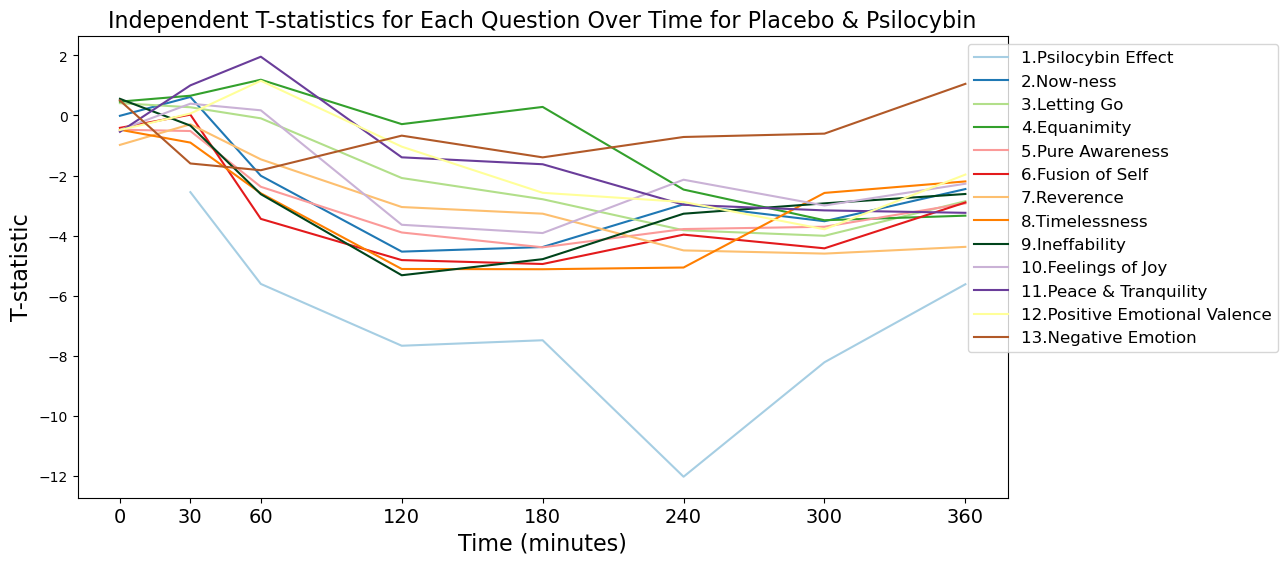

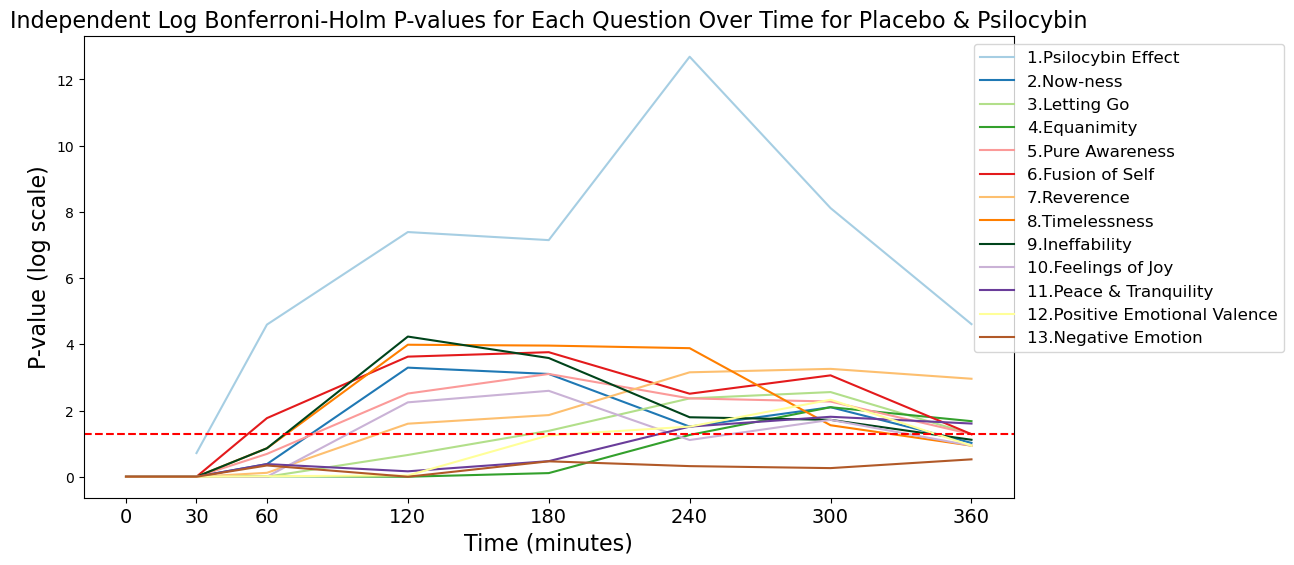

In [316]:
t_stats_by_question_independent = {col: [] for col in rating_columns}
log_p_value_by_question_independent = {col: [] for col in rating_columns}

for timepoint in timepoints:
    for col in rating_columns:
        t_stat, log_bonferroni_holm_p_value = independent_results_by_time[timepoint][col]
        t_stats_by_question_independent[col].append(t_stat if t_stat is not None else np.nan)
        log_p_value_by_question_independent[col].append(log_bonferroni_holm_p_value if log_bonferroni_holm_p_value is not None else np.nan)

plt.figure(figsize=(12, 6))
for i, (col, short_col) in enumerate(zip(rating_columns, shortened_rating_columns)):
    plt.plot(timepoints, t_stats_by_question_independent[col], label=short_col, color=custom_colors[i])
plt.xlabel('Time (minutes)', fontsize=16)
plt.ylabel('T-statistic', fontsize=16)
plt.title('Independent T-statistics for Each Question Over Time for Placebo & Psilocybin', fontsize=16)
plt.xticks(specific_timepoints, fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=12)
plt.show()

plt.figure(figsize=(12, 6))
for i, (col, short_col) in enumerate(zip(rating_columns, shortened_rating_columns)):
    plt.plot(timepoints, log_p_value_by_question_independent[col], label=short_col, color=custom_colors[i])
plt.xlabel('Time (minutes)', fontsize=16)
plt.ylabel('P-value (log scale)', fontsize=16)
plt.title('Independent Log Bonferroni-Holm P-values for Each Question Over Time for Placebo & Psilocybin', fontsize=16)
plt.xticks(specific_timepoints, fontsize=14)
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=12)
plt.show()

## Heatmap comparing Wilcoxon and Independent T-statstic

In [95]:
t_stats_df = pd.DataFrame(t_stats_by_question_independent, index=timepoints).T
wilcoxon_stats_df = pd.DataFrame(t_stats_by_question, index=timepoints).T

t_stats_df_normalized = (t_stats_df - t_stats_df.min().min()) / (t_stats_df.max().max() - t_stats_df.min().min())
wilcoxon_stats_df_normalized = (wilcoxon_stats_df - wilcoxon_stats_df.min().min()) / (wilcoxon_stats_df.max().max() - wilcoxon_stats_df.max().max())

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
sns.heatmap(t_stats_df_normalized, cmap='coolwarm', annot=False, cbar_kws={'label': 'T-Statistic (Normalized)'}, 
            yticklabels=shortened_rating_columns, linewidths=0.5, linecolor='white', square=True)
plt.title('T-Statistics Heatmap')
plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Question', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.subplot(1, 2, 2)
sns.heatmap(wilcoxon_stats_df_normalized, cmap='coolwarm', annot=False, cbar_kws={'label': 'Wilcoxon Statistic (Normalized)'}, 
            yticklabels=shortened_rating_columns, linewidths=0.5, linecolor='white', square=True)
plt.title('Wilcoxon Statistics Heatmap')
plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Question', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

NameError: name 't_stats_by_question_independent' is not defined

Raw Wilcoxon Results (before normalization):
                                                     0     30    60    120  \
1. Overall Psilocybin Effect (0 = none to\n10 =...   0.0   0.0   3.0  14.0   
2. Now-ness (0 = none to\n10 = strongest imagin...  27.0   9.0  18.0   7.0   
3. Letting Go (0 = none to\n10 = strongest imag...  18.0  16.5  15.5  18.0   
4. Equanimity (0 = none to\n10 = strongest imag...   2.0   3.5   0.0   3.0   
5. Pure being and pure awareness (0 = none to\n...  27.0  14.5  23.5  10.5   
6. Fusion of your personal self into a larger w...   2.0  10.0   7.5   8.0   
7. Sense of reverence or sacredness (0 = none t...  10.0  21.0  13.5   6.0   
8. Timelessness (0 = none to\n10 = strongest im...   2.5  13.0  16.5   7.0   
9. Ineffability (0 = none to\n10 = strongest im...  17.0   9.0   2.5   6.0   
10. Feelings of joy (0 = none to\n10 = stronges...  21.5  14.0  10.5  11.0   
11. Feelings of peace and tranquility (0 = none...  13.5  19.0  29.0  17.5   
12. Positive Emotio

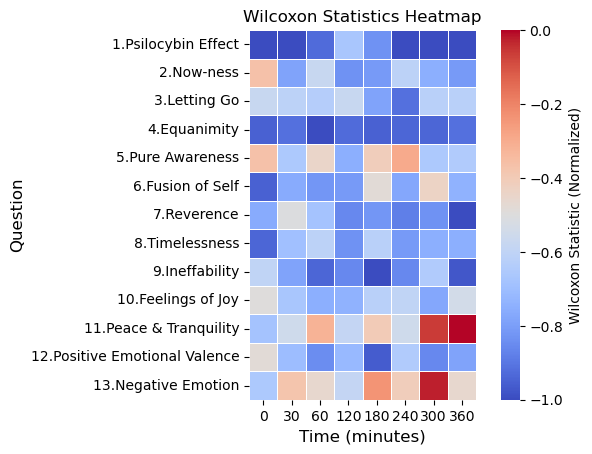

In [99]:
# Check and print raw Wilcoxon statistics data
print("Raw Wilcoxon Results (before normalization):")
print(wilcoxon_stats_df)

# Ensure normalization consistency by printing min/max values
print("Wilcoxon Statistics Min:", wilcoxon_stats_df.min().min())
print("Wilcoxon Statistics Max:", wilcoxon_stats_df.max().max())

wilcoxon_stats_df = pd.DataFrame(t_stats_by_question, index=timepoints).T
print(wilcoxon_stats_df)
# Apply normalization
wilcoxon_stats_df_normalized = (wilcoxon_stats_df - wilcoxon_stats_df.min().min()) / (wilcoxon_stats_df.max().max() - wilcoxon_stats_df.min().min())

sns.heatmap(wilcoxon_stats_df_normalized, cmap='coolwarm', annot=False, cbar_kws={'label': 'Wilcoxon Statistic (Normalized)'}, 
            yticklabels=shortened_rating_columns, linewidths=0.5, linecolor='white', square=True)
plt.title('Wilcoxon Statistics Heatmap')
plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Question', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


## Data Exploration

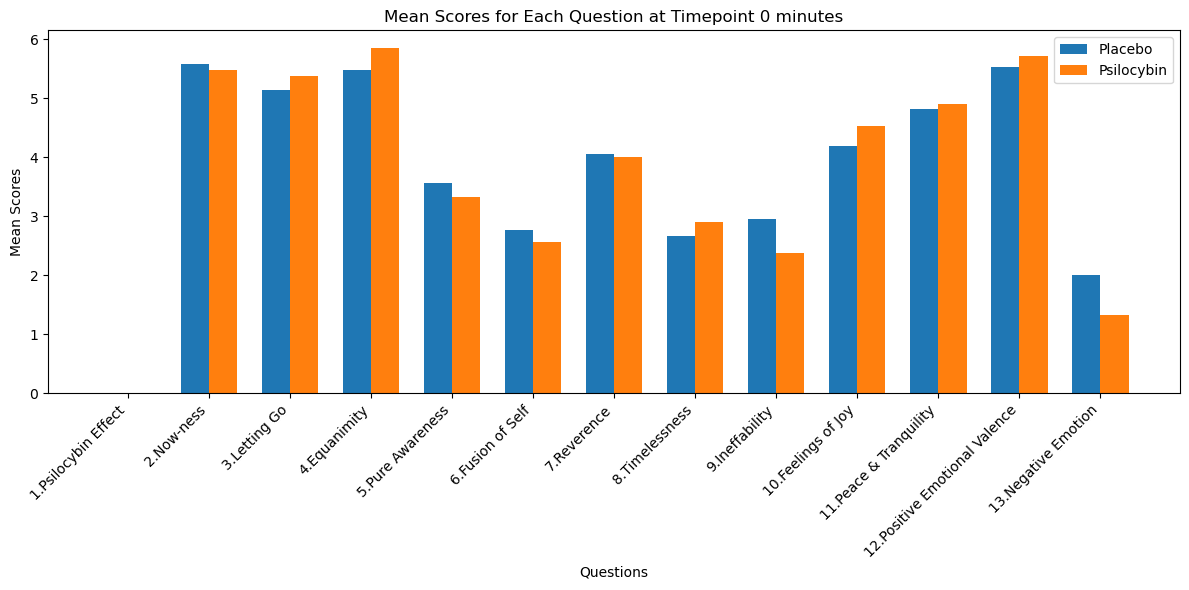

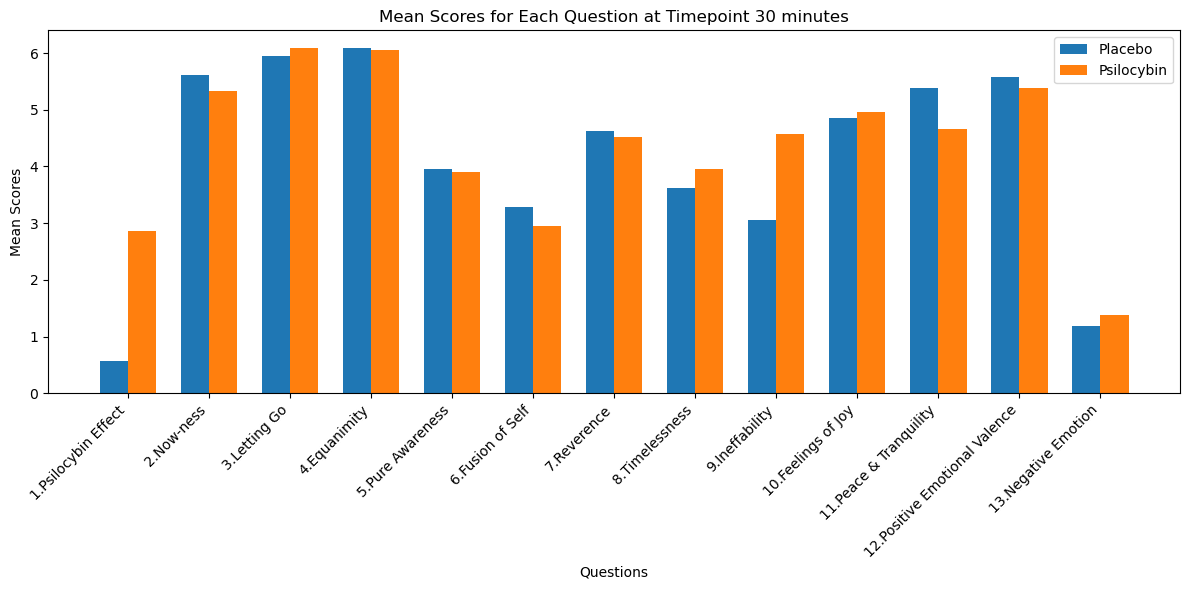

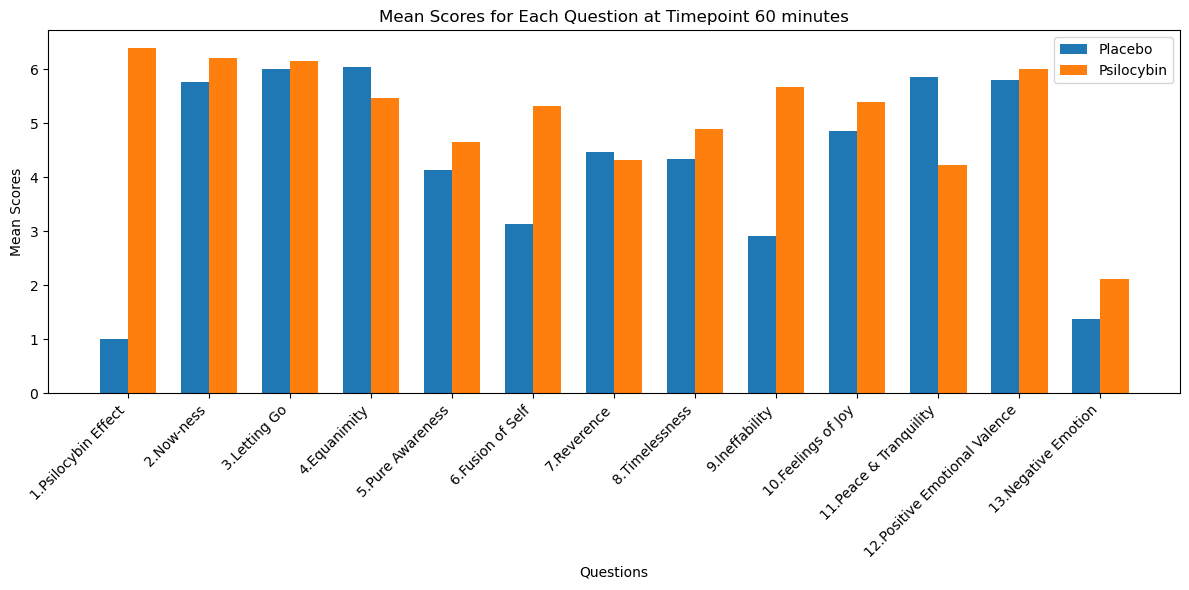

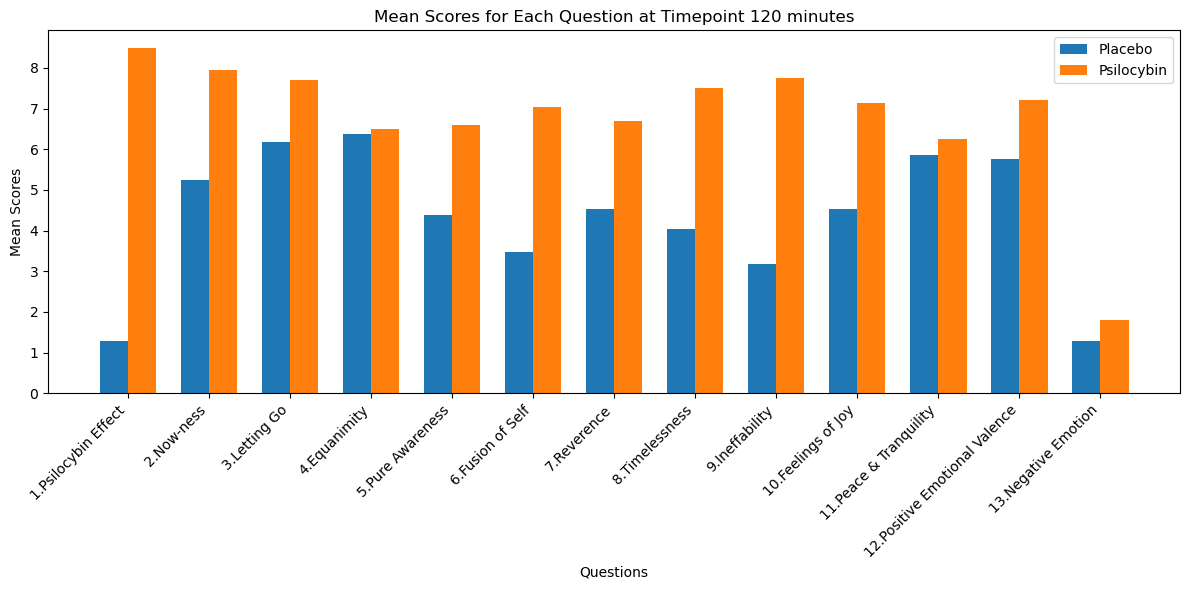

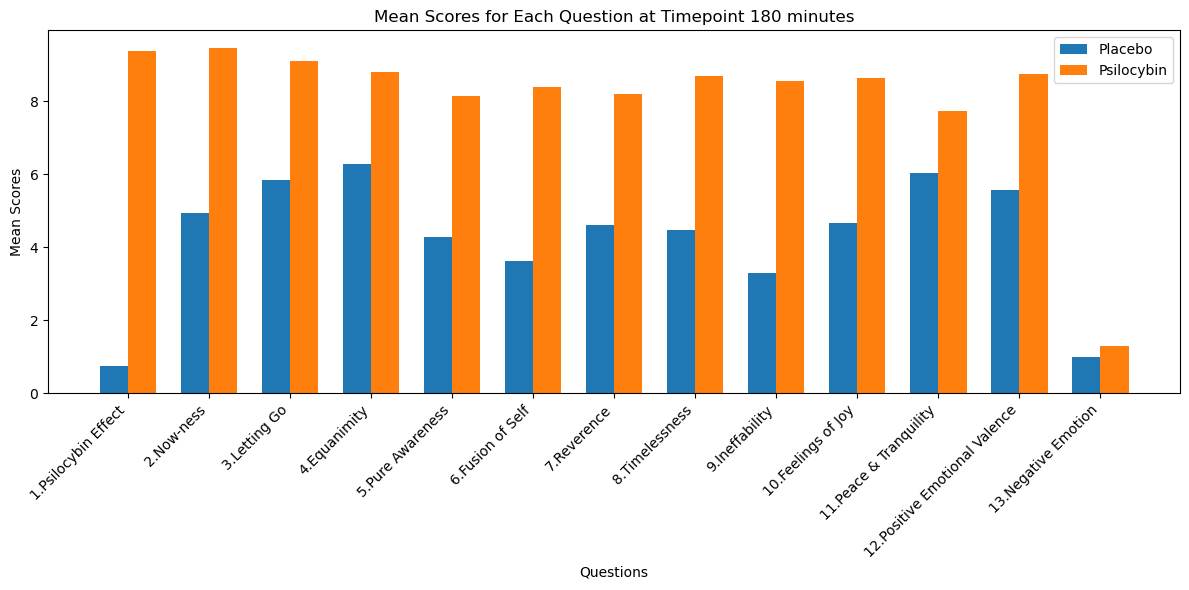

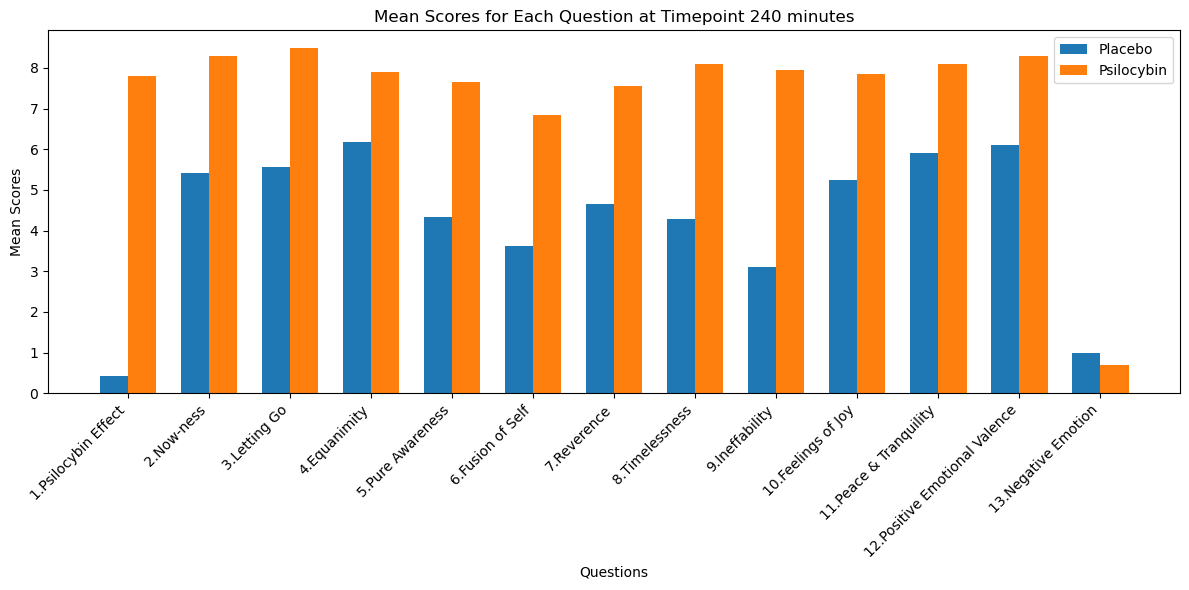

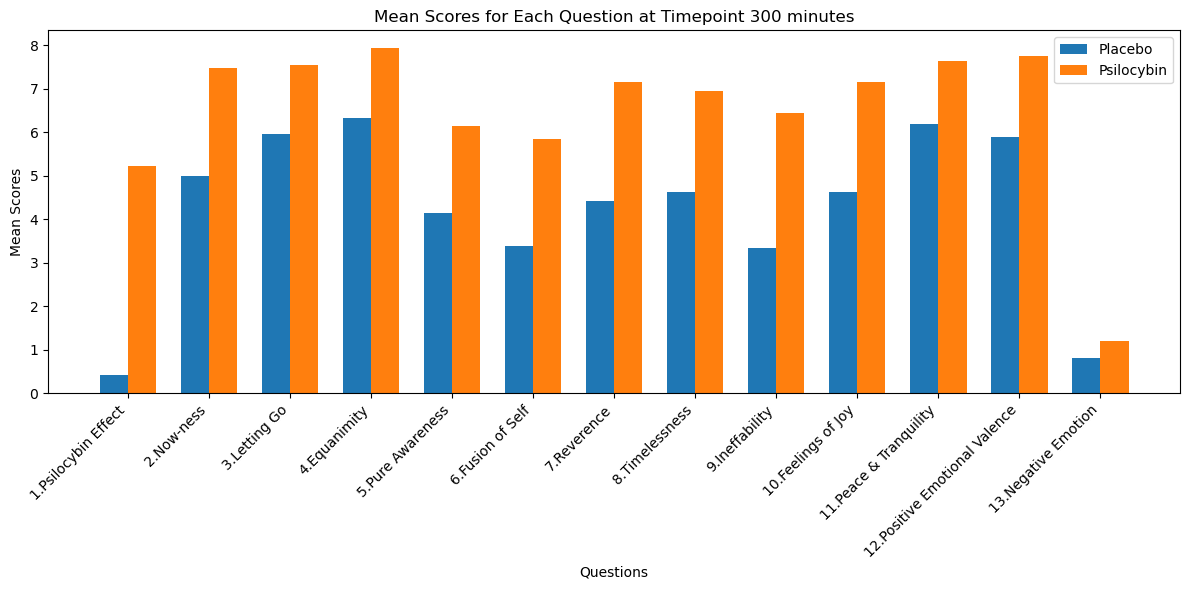

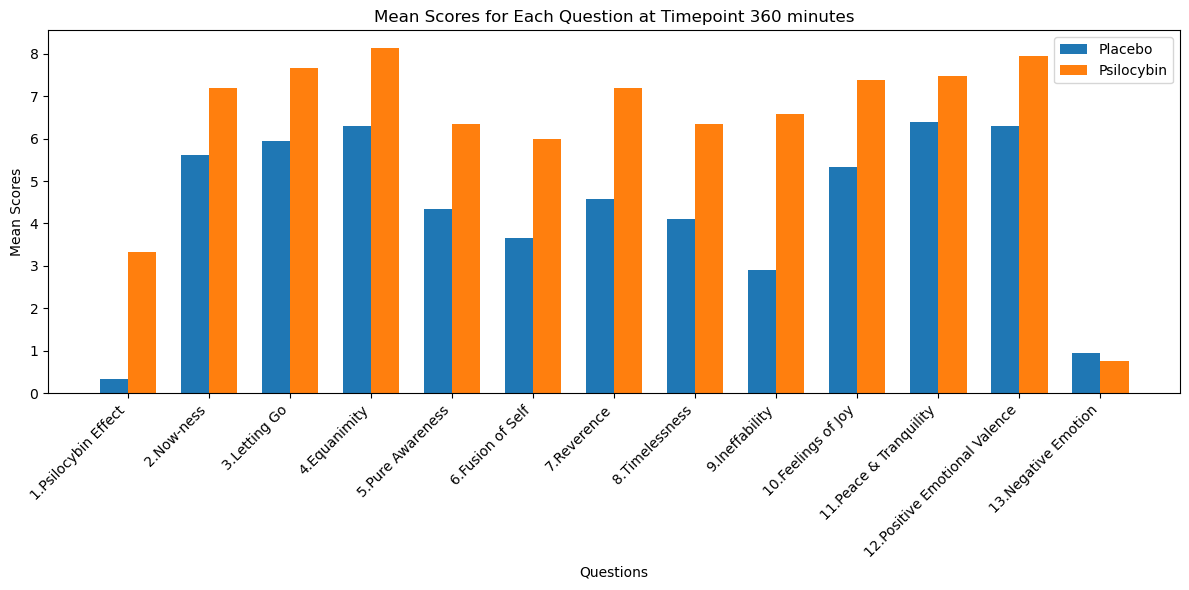

In [33]:
for timepoint in timepoints:
    # Filter data for the current timepoint and section 1
    df_timepoint = df_cleaned[df_cleaned['Timepoint relative to drug administration (in minutes)'] == timepoint]

    df_placebo = df_timepoint[(df_timepoint['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'PLA') & (df_timepoint['Session (1, 2)'] == 1)]
    df_exp = df_timepoint[(df_timepoint['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'EXP') & (df_timepoint['Session (1, 2)'] == 2)]
    
    placebo_means = df_placebo[rating_columns].mean()
    exp_means = df_exp[rating_columns].mean()

    # Create a bar plot
    x = np.arange(len(rating_columns))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Bar plot for placebo and psilocybin
    ax.bar(x - width/2, placebo_means, width, label='Placebo')
    ax.bar(x + width/2, exp_means, width, label='Psilocybin')

    # Add labels, title, and custom x-axis tick labels
    ax.set_xlabel('Questions')
    ax.set_ylabel('Mean Scores')
    ax.set_title(f'Mean Scores for Each Question at Timepoint {timepoint} minutes')
    ax.set_xticks(x)
    ax.set_xticklabels(shortened_rating_columns, rotation=45, ha='right')
    ax.legend()

    fig.tight_layout()
    plt.show()

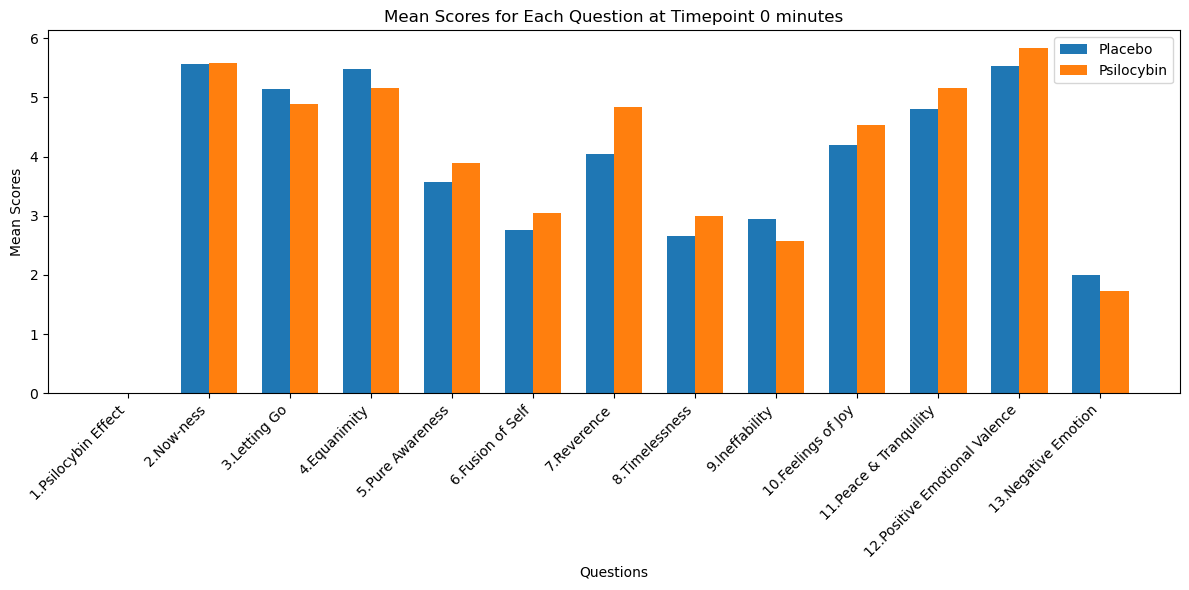

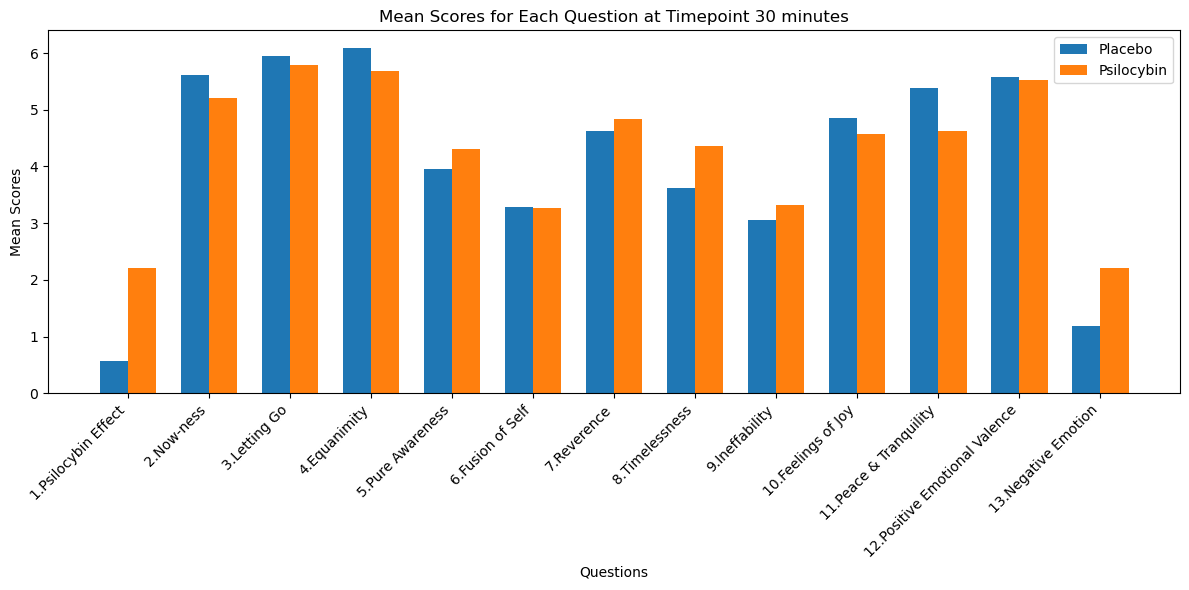

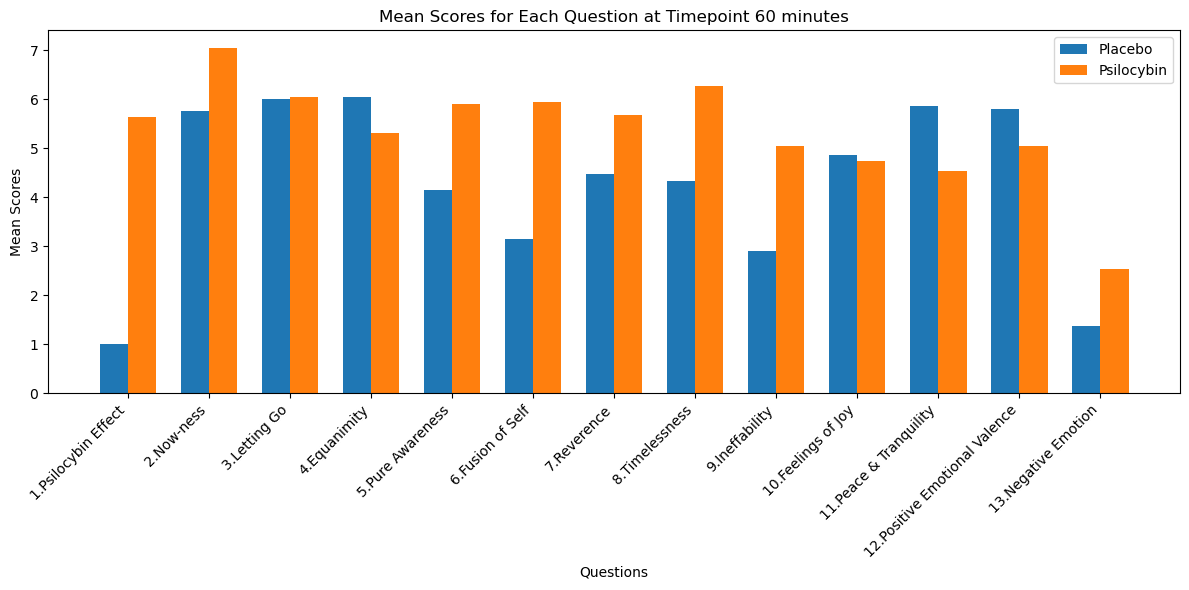

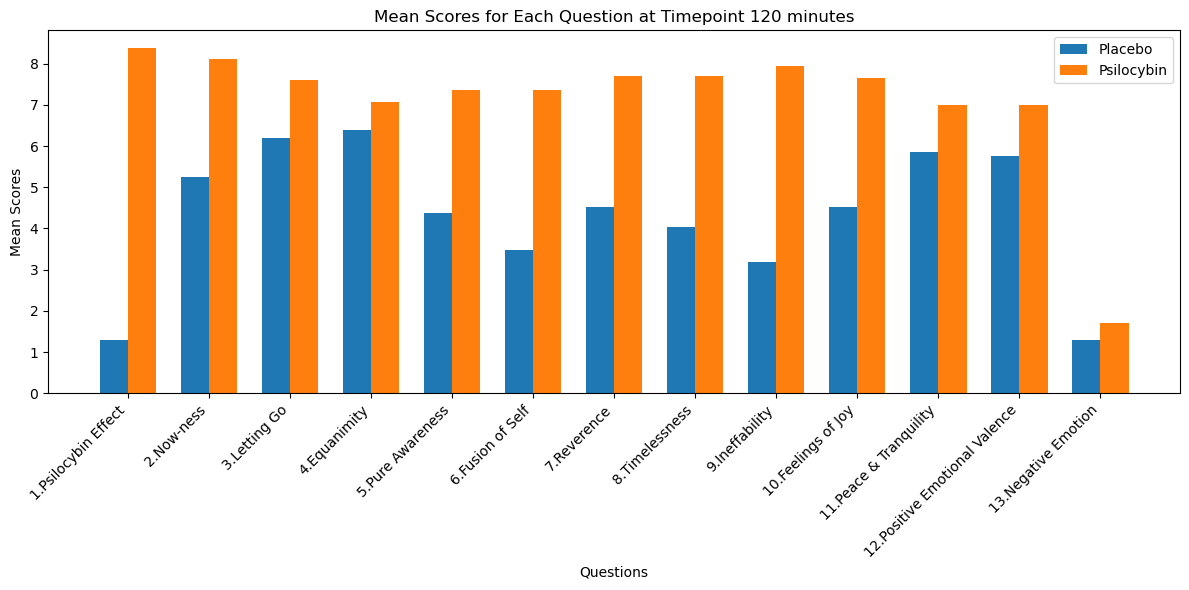

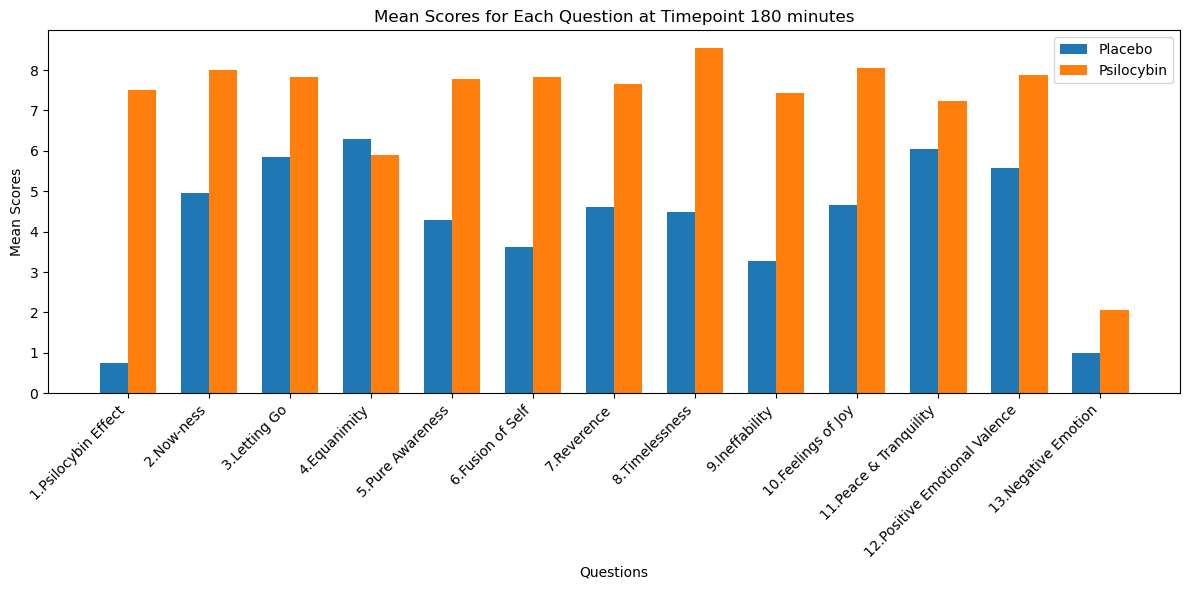

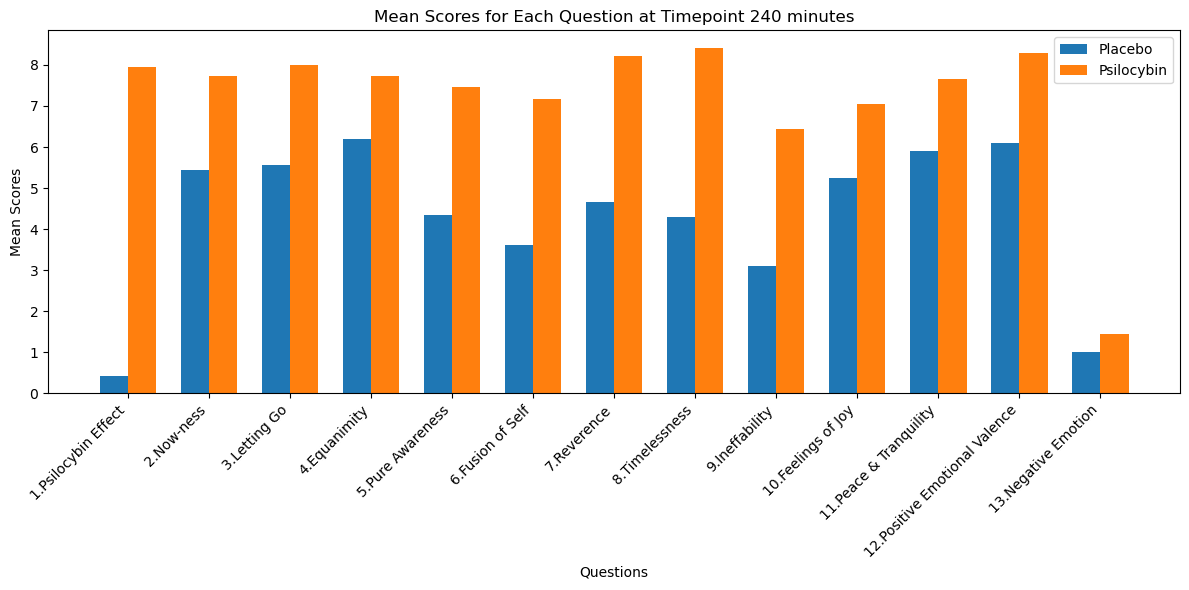

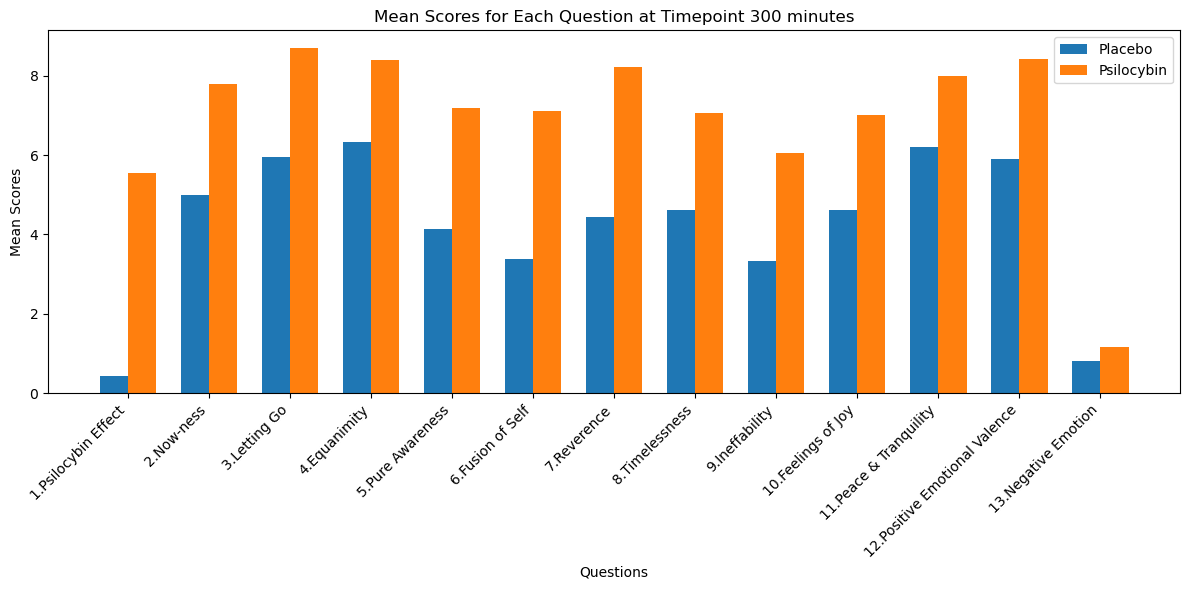

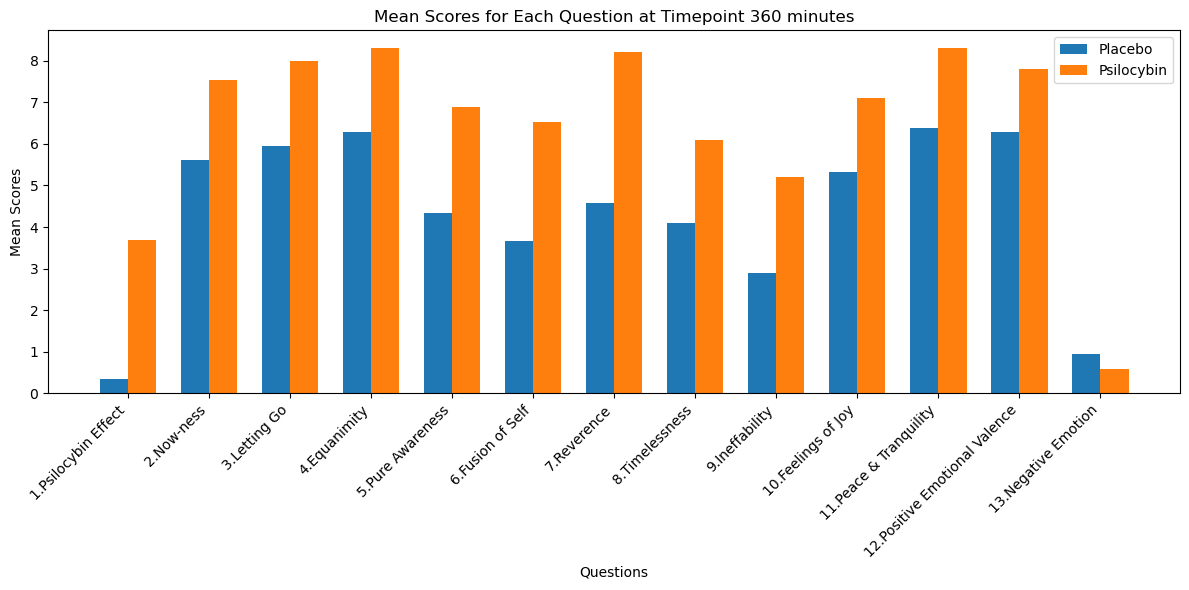

In [34]:
for timepoint in timepoints:
    df_timepoint = df_cleaned[df_cleaned['Timepoint relative to drug administration (in minutes)'] == timepoint]
    df_placebo = df_timepoint[(df_timepoint['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'PLA') & (df_timepoint['Session (1, 2)'] == 1)]
    df_psilocybin = df_timepoint[(df_timepoint['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'PSIL') & (df_timepoint['Session (1, 2)'] == 1)]

    placebo_means = df_placebo[rating_columns].mean()
    psilocybin_means = df_psilocybin[rating_columns].mean()

    x = np.arange(len(rating_columns))
    width = 0.35 
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.bar(x - width/2, placebo_means, width, label='Placebo')
    ax.bar(x + width/2, psilocybin_means, width, label='Psilocybin')

    ax.set_xlabel('Questions')
    ax.set_ylabel('Mean Scores')
    ax.set_title(f'Mean Scores for Each Question at Timepoint {timepoint} minutes')
    ax.set_xticks(x)
    ax.set_xticklabels(shortened_rating_columns, rotation=45, ha='right')
    ax.legend()

    fig.tight_layout()
    plt.show()

In [36]:
df[rating_columns] = df[rating_columns].apply(pd.to_numeric, errors='coerce')

In [39]:
session_1 = df[df['Session (1, 2)'] == 1]
session_2 = df[df['Session (1, 2)'] == 2]
crossover_participants = session_1[(session_1['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'PLA')]

In [41]:
results_paired = {}
for col in rating_columns:
    placebo_scores = session_1[session_1['Volunteer number'].isin(crossover_participants['Volunteer number'])][col]
    psilocybin_scores = session_2[session_2['Volunteer number'].isin(crossover_participants['Volunteer number'])][col]
        # Perform paired t-test
    t_stat, p_value = stats.ttest_rel(placebo_scores, psilocybin_scores, nan_policy='omit')
    results_paired[col] = (t_stat, p_value)

for col, (t_stat, p_value) in results_paired.items():
    print(f"{col}: T-statistic = {t_stat}, P-value = {p_value}")

ValueError: unequal length arrays

For the participants who received placebo in session 1 and were crossed over to psilocybin in session 2,  a paired t-test was performed for each subjective rating variable. This test was performed to determine if there was a significant difference in responses before and after the crossover from placebo to psilocybin.
The results indicated significant differences between conditions for most variables, such as "Overall Psilocybin Effect", "Now-ness", "Letting Go", and others, with extremely low p-values, implying strong statistical significance.

In [43]:
psilocybin_only = session_1[session_1['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'PSIL']
placebo_only = session_1[session_1['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'PLA']
#for col in rating_columns:
   #print(f"{col}: {placebo_only[col].isna().sum()} missing values in placebo group")
   #print(f"{col}: {psilocybin_only[col].isna().sum()} missing values in psilocybin group")
placebo_only_cleaned = placebo_only.dropna(subset=rating_columns)
psilocybin_only_cleaned = psilocybin_only.dropna(subset=rating_columns)
#print(placebo_only.shape)
#print(placebo_only_cleaned.shape)

In [45]:
results_independent = {}
for col in rating_columns:
    placebo_scores = placebo_only[col]
    psilocybin_scores = psilocybin_only[col]
    
    # Perform the two-sample t-test
    t_stat, p_value = stats.ttest_ind(placebo_scores, psilocybin_scores, nan_policy='omit')
    results_independent[col] = (t_stat, p_value)

for col, (t_stat, p_value) in results_independent.items():
    print(f"{col}: T-statistic = {t_stat}, P-value = {p_value}")

1. Overall Psilocybin Effect (0 = none to
10 = strongest imaginable): T-statistic = -15.429444401377932, P-value = 1.82996864804383e-41
2. Now-ness (0 = none to
10 = strongest imaginable): T-statistic = -5.807565754223764, P-value = 1.408653081980698e-08
3. Letting Go (0 = none to
10 = strongest imaginable): T-statistic = -3.4222356395405535, P-value = 0.000693751208854987
4. Equanimity (0 = none to
10 = strongest imaginable): T-statistic = -1.0788089163713, P-value = 0.28140743509900423
5. Pure being and pure awareness (0 = none to
10 = strongest imaginable): T-statistic = -7.920759406904275, P-value = 3.10622139867374e-14
6. Fusion of your personal self into a larger whole (0 = none to
10 = strongest imaginable): T-statistic = -8.695702299863871, P-value = 1.322030541783588e-16
7. Sense of reverence or sacredness (0 = none to
10 = strongest imaginable): T-statistic = -8.321093126288845, P-value = 1.9135481802495092e-15
8. Timelessness (0 = none to
10 = strongest imaginable): T-statis

In [47]:
for col in rating_columns:
    placebo_scores = placebo_only_cleaned[col]
    psilocybin_scores = psilocybin_only_cleaned[col]
    t_stat, p_value = stats.ttest_ind(placebo_scores, psilocybin_scores, nan_policy='omit')
    results_independent[col] = (t_stat, p_value)

for col, (t_stat, p_value) in results_independent.items():
    print(f"{col}: T-statistic = {t_stat}, P-value = {p_value}")

1. Overall Psilocybin Effect (0 = none to
10 = strongest imaginable): T-statistic = -15.121591921917284, P-value = 3.919616204202543e-40
2. Now-ness (0 = none to
10 = strongest imaginable): T-statistic = -5.7045505543911155, P-value = 2.480418165038184e-08
3. Letting Go (0 = none to
10 = strongest imaginable): T-statistic = -3.2329655931459844, P-value = 0.0013412746126078713
4. Equanimity (0 = none to
10 = strongest imaginable): T-statistic = -0.9192942150934472, P-value = 0.35857301622430715
5. Pure being and pure awareness (0 = none to
10 = strongest imaginable): T-statistic = -7.7813754952725285, P-value = 8.100984271662408e-14
6. Fusion of your personal self into a larger whole (0 = none to
10 = strongest imaginable): T-statistic = -8.56778916092202, P-value = 3.387383170660452e-16
7. Sense of reverence or sacredness (0 = none to
10 = strongest imaginable): T-statistic = -8.094743032561867, P-value = 9.520313653651218e-15
8. Timelessness (0 = none to
10 = strongest imaginable): T-

 an independent t-test for participants who received either psilocybin or placebo in session 1, comparing these two groups. This test was first conducted with missing data and later with cleaned data (remove NaN).For the cleaned data, you found significant differences between the psilocybin and placebo groups across several variables, including "Overall Psilocybin Effect", "Letting Go", "Sense of reverence or sacredness", and others, with p-values showing strong statistical significance (e.g., p-values < 0.001)

Both the paired and independent t-tests indicated that psilocybin had a statistically significant effect on participants' subjective experiences when compared to placebo. 

## Trying Lazy Predict

In [95]:
!pip install opendatasets --upgrade --quiet
!pip3 install lazypredict 
!pip3 install graphviz

In [103]:

import os
import numpy as np
import pandas as pd
import opendatasets as od
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier # for Random Forest Classifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [112]:
X = df[rating_columns]  
y = df['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)']

In [114]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit and predict
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# View results
print(models)

100%|██████████| 31/31 [00:03<00:00, 10.29it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 183
[LightGBM] [Info] Number of data points in the train set: 488, number of used features: 8
[LightGBM] [Info] Start training from score -1.025529
[LightGBM] [Info] Start training from score -1.042821
[LightGBM] [Info] Start training from score -1.241556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

## Some Random PCA I done

In [116]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [146]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(df[rating_columns]) 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [172]:
pca = PCA(n_components=X_scaled.shape[1]) 
X_pca = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)
print("Total Variance Explained by 2 components:", sum(explained_variance))

Explained Variance Ratio: [0.62776203 0.14278614 0.0789812  0.04592319 0.03807703 0.02993752
 0.01986962 0.01666328]
Total Variance Explained by 2 components: 0.9999999999999999


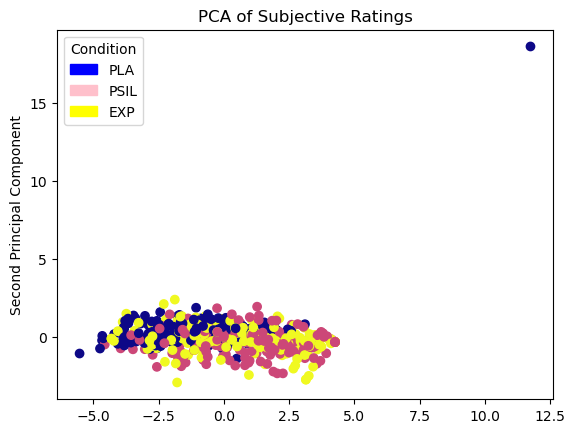

In [206]:
import matplotlib.patches as mpatches
df['Condition_encoded'] = df['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'].map({'PLA': 0, 'PSIL': 1, 'EXP':2})

# Use the encoded values for the 'c' argument
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Condition_encoded'], cmap='plasma')
plt.ylabel('Second Principal Component')
plt.title('PCA of Subjective Ratings')
legend_handles = [mpatches.Patch(color='blue', label='PLA'),
                  mpatches.Patch(color='pink', label='PSIL'),
                  mpatches.Patch(color='yellow', label='EXP')]
plt.legend(handles=legend_handles, title='Condition')
plt.show()

In [208]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=X_scaled.shape[1], random_state=42)
X_ica = ica.fit_transform(X_scaled)


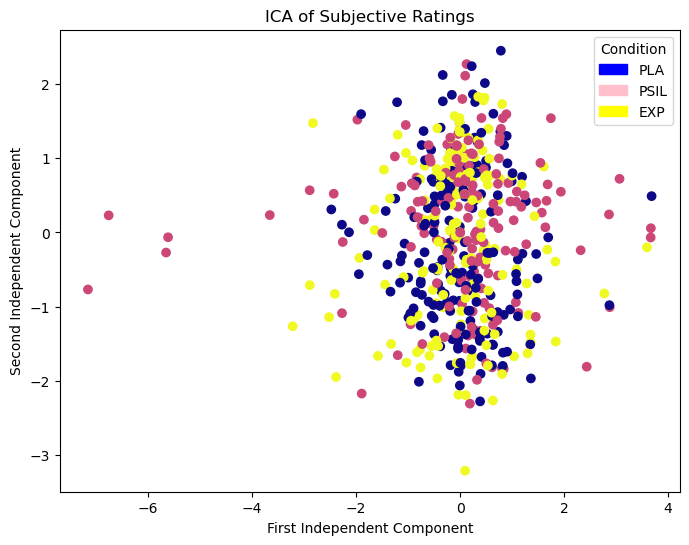

In [216]:
plt.figure(figsize=(8, 6))
plt.scatter(X_ica[:, 0], X_ica[:, 1], c=df['Condition_encoded'], cmap='plasma')
plt.xlabel('First Independent Component')
plt.ylabel('Second Independent Component')
plt.title('ICA of Subjective Ratings')
#plt.colorbar(label='Condition (PLA, PSIL, EXP)')
nd_handles = [mpatches.Patch(color='blue', label='PLA'),
                  mpatches.Patch(color='pink', label='PSIL'),
                  mpatches.Patch(color='yellow', label='EXP')]
plt.legend(handles=legend_handles, title='Condition')
plt.show()